In [120]:
import os
import shutil
import random 

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchvision import transforms,datasets
from torch.utils.data import DataLoader



In [121]:
# Set the main directory
main_directory = "MP3_train_test_sets_2"
maincat_directory = "Micro_Organism"


# Create train and test directories
train_directory = os.path.join(main_directory, "train")
test_directory = os.path.join(main_directory, "test")
extratest_directory = os.path.join(main_directory, "extra_test")


# Iterate through each category
for category in os.listdir(maincat_directory):
    category_path = os.path.join(maincat_directory, category)
    
    # Create subdirectories for each category
    train_category_path = os.path.join(train_directory, category)
    test_category_path = os.path.join(test_directory, category)
    extratest_category_path = os.path.join(extratest_directory, category)
    
    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(test_category_path, exist_ok=True)
    os.makedirs(extratest_category_path, exist_ok=True)
    
    #list of all images in the category
    images = os.listdir(category_path)
    
    # Take 5 random images for the test 
    test_images = random.sample(images, 5)

    extratest_images = random.sample(images, 1)

    
    for image in images:
        image_path = os.path.join(category_path, image)
        
        # Copy images to train or test directory based on the split
        if image in test_images:
            shutil.copy(image_path, os.path.join(test_category_path, image))
        elif image in extratest_images:
            shutil.copy(image_path, os.path.join(extratest_category_path, image))
        else:
            shutil.copy(image_path, os.path.join(train_category_path, image))

print("Dataset split into train and test sets")

Dataset split into train and test sets


In [122]:

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [123]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [124]:

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), #  Reshape all images to 224x224 
    transforms.ToTensor(), #Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # A mean of [0.485, 0.456, 0.406] 
                         std=[0.229, 0.224, 0.225]) # A standard deviation of [0.229, 0.224, 0.225] 
])

In [125]:
# Set path

train = 'MP3_train_test_sets_2/train'
test = 'MP3_train_test_sets_2/test'

# Use ImageFolder to create the train and test data

train_data = datasets.ImageFolder(train,transform=manual_transforms)
test_data = datasets.ImageFolder(test, transform=manual_transforms)

In [126]:
# Create dataloaders
num_workers = 8
batch_size = 16

class_names = train_data.classes
print(f"Classes in this dataset: {class_names}")

train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)

Classes in this dataset: ['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']


In [127]:
import timm
from transformers import AutoImageProcessor, ViTModel

#load model using timm which creates the vit base patch16 pretrained model
model = timm.create_model('vit_base_patch16_224', pretrained=True)



In [128]:
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)    [32, 3, 224, 224]    [32, 1000]           152,064              True
├─PatchEmbed (patch_embed)               [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (proj)                     [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Identity (norm)                   [32, 196, 768]       [32, 196, 768]       --                   --
├─Dropout (pos_drop)                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity (patch_drop)                  [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity (norm_pre)                    [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (blocks)                    [32, 197, 768]       [32, 197, 768]       --                   True
│    └─Block (0)      

In [129]:
for param in model.parameters():
    param.requires_grad = False
    
#modify 
model.head = nn.Linear(in_features=768, out_features=len(class_names), bias=True).to(device)

In [130]:
from torchinfo import summary

# Print a summary 
summary(model=model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)    [32, 3, 224, 224]    [32, 8]              152,064              Partial
├─PatchEmbed (patch_embed)               [32, 3, 224, 224]    [32, 196, 768]       --                   False
│    └─Conv2d (proj)                     [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
│    └─Identity (norm)                   [32, 196, 768]       [32, 196, 768]       --                   --
├─Dropout (pos_drop)                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity (patch_drop)                  [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity (norm_pre)                    [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (blocks)                    [32, 197, 768]       [32, 197, 768]       --                   False
│    └─Block (0)

In [131]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [132]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()


# Train the classifier head of the pretrained ViT feature extractor model

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        average_val_loss = val_loss / len(test_dataloader)
        accuracy = correct / total

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_val_loss:.4f}, Accuracy: {accuracy:.4%}')



Epoch [1/5], Loss: 1.0071, Accuracy: 70.0000%
Epoch [2/5], Loss: 0.9443, Accuracy: 72.5000%
Epoch [3/5], Loss: 0.8164, Accuracy: 77.5000%
Epoch [4/5], Loss: 0.7391, Accuracy: 72.5000%
Epoch [5/5], Loss: 0.6764, Accuracy: 75.0000%


In [133]:
# Save the fine-tuned model checkpoint
torch.save(model.state_dict(), 'vit_model.pth')

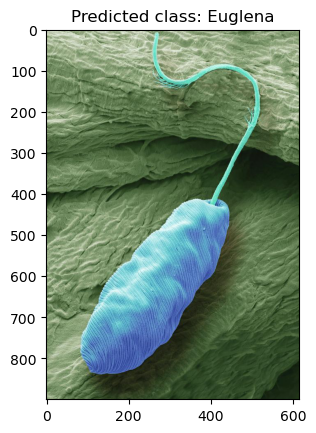

In [135]:
import requests
import os
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup image path

image_path = 'MP3_train_test_sets_2/extra_test/Euglena/Image_68.jpg'
input_image = Image.open(image_path)
input_tensor = manual_transforms(input_image)
input_batch = input_tensor.unsqueeze(0)

# Make prediction
with torch.no_grad():
    outputs = model(input_batch)
    _, predicted_class = torch.max(outputs, 1)


# Display the image with prediction and accuracy
plt.imshow(input_image)
plt.title(f'Predicted class: {class_names[predicted_class[0]]}')
plt.show()
